In [1]:
import confirm.outlaw.nb_util as nb_util
nb_util.setup_nb()

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax
# Run on CPU because a concurrent process is probably running on GPU.
jax.config.update('jax_platform_name', 'cpu')

import lewis_tune_sim as lts
from confirm.lewislib import lewis

In [2]:
import pickle
with open('3d/68.pkl', 'rb') as f:
    data = pickle.load(f)
g, sim_sizes, sim_cvs, _, _, pointwise_target_alpha = data

In [3]:
# Configuration used during simulation
name = "3d"
params = {
    "n_arms": 3,
    "n_stage_1": 50,
    "n_stage_2": 100,
    "n_stage_1_interims": 2,
    "n_stage_1_add_per_interim": 100,
    "n_stage_2_add_per_interim": 100,
    "stage_1_futility_threshold": 0.15,
    "stage_1_efficacy_threshold": 0.7,
    "stage_2_futility_threshold": 0.2,
    "stage_2_efficacy_threshold": 0.95,
    "inter_stage_futility_threshold": 0.6,
    "posterior_difference_threshold": 0,
    "rejection_threshold": 0.05,
    "key": jax.random.PRNGKey(0),
    "n_table_pts": 20,
    "n_pr_sims": 100,
    "n_sig2_sims": 20,
    "batch_size": int(2**12),
    "cache_tables": f"./{name}/lei_cache.pkl",
}
lei_obj = lewis.Lewis45(**params)

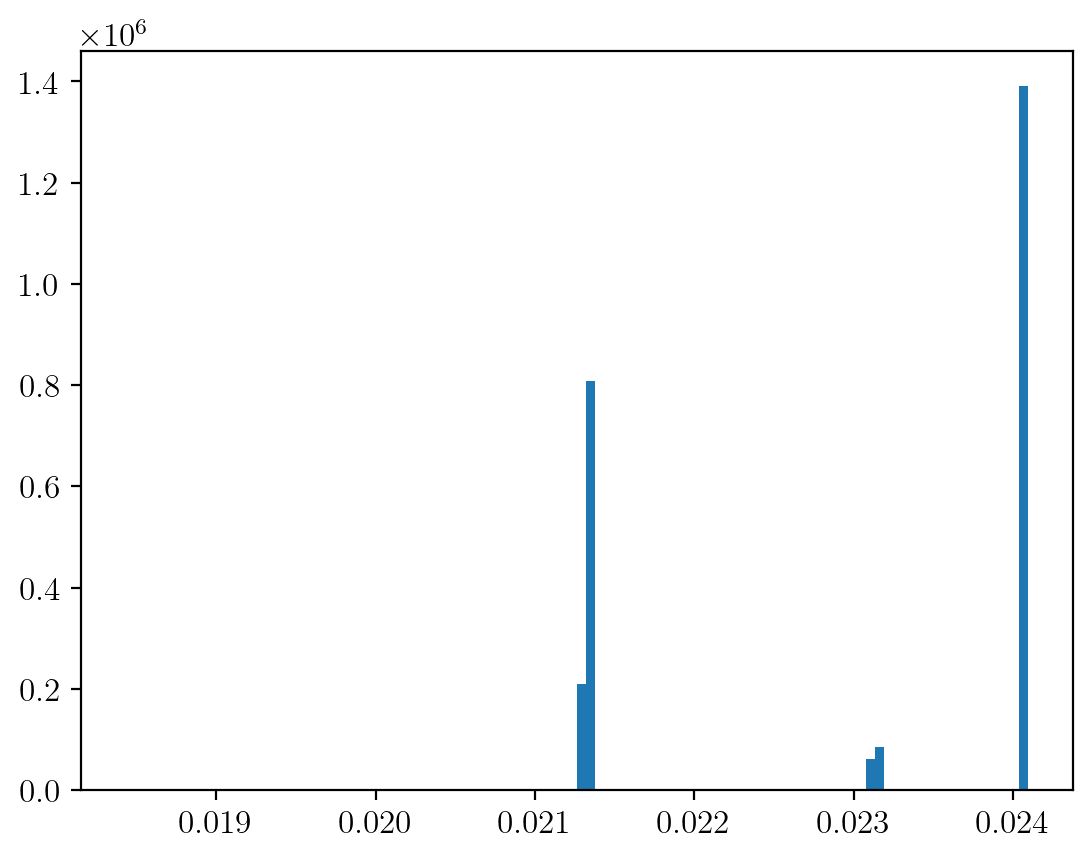

In [4]:
plt.hist(pointwise_target_alpha[sim_cvs == 0], bins=100)
plt.show()

In [44]:
key = jax.random.PRNGKey(0)
unifs = jax.random.uniform(key=key, shape=(np.max(sim_sizes),) + lei_obj.unifs_shape())
unifs_order = np.arange(0, unifs.shape[1])

batch_size = 2**4
idxs = np.where(sim_cvs == 0)[0][:batch_size]
overall_cv = 0
simv = jax.jit(
    jax.vmap(lts.sim, in_axes=(None, 0, None, None)), static_argnums=(0,)
)
tunev = jax.jit(jax.vmap(lts.tune, in_axes=(None, 0, 0, 0, None, None)), static_argnums=(0,))
rejv = jax.jit(
    jax.vmap(lts.rej, in_axes=(None, 0, 0, 0, None, None)), static_argnums=(0,)
)
batched_sim = lts.grouped_by_sim_size(lei_obj, simv, batch_size, n_out=2)
batched_rej = lts.grouped_by_sim_size(lei_obj, rejv, batch_size)
batched_tune = lts.grouped_by_sim_size(lei_obj, tunev, batch_size)

In [49]:
test_stats, best_arms = lts.simv(lei_obj, g.theta_tiles[idxs], unifs[:1000], unifs_order[:1000])

In [69]:
alpha = pointwise_target_alpha[idxs[0]]
cv_idx = jnp.maximum(
    jnp.floor((unifs.shape[0] + 1) * jnp.maximum(alpha, 0)).astype(int) - 1, 0
)
cv_idx

DeviceArray(23, dtype=int64)

In [60]:
sortedts = jnp.sort(test_stats[0])
sortedts

DeviceArray([0.        , 0.00526097, 0.00570855, 0.01033178, 0.01063929, 0.02898933, 0.03028939,
             0.03182161, 0.0372274 , 0.03983137, 0.04402515, 0.04562993, 0.04808738, 0.0525456 ,
             0.07057453, 0.08338165, 0.08699439, 0.0903775 , 0.09353179, 0.09524129, 0.0986853 ,
             0.10353585, 0.10785986, 0.12315217, 0.13706904, 0.13781289, 0.18404676, 0.19944814,
             0.21396142, 0.21507338, 0.21704441, 0.22825735, 0.24719905, 0.26880212, 0.27820072,
             0.2824309 , 0.29691021, 0.360772  , 0.37241344, 0.38689041, 0.39546072, 0.41572249,
             0.42838576, 0.54316623, 1.        , 1.        , 1.        , 1.        , 1.        ,
             1.        , 1.        , 1.        , 1.        , 1.        , 1.        , 1.        ,
             1.        , 1.        , 1.        , 1.        , 1.        , 1.        , 1.        ,
             1.        , 1.        , 1.        , 1.        , 1.        , 1.        , 1.        ,
             1.        , 1.   

In [41]:
unifs.shape

(1000, 350, 3)

In [39]:
test_stats, best_arm = batched_sim(sim_sizes[idxs], [g.theta_tiles[idxs]], [unifs, unifs_order])

ValueError: shape mismatch: value array of shape (0,1000) could not be broadcast to indexing result of shape (16,1000)

In [ ]:
test_stats.shape

(1000,)

In [ ]:
typeI_sum = batched_sim(
    sim_sizes[idxs],
    np.full(idxs.shape[0], overall_cv),
    g.theta_tiles[idxs],
    g.null_truth[idxs],
    unifs,
    unifs_order,
)